In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import sys, json, time
import plotly.express as px
import geopandas
import networkx as nx
import pygraphviz
from shapely.geometry import Point, LineString, shape

sys.path.append("../src")

In [2]:
# Set app root path
BASE_DIR = path.abspath("..")

# print the app path
BASE_DIR

'/Users/raf/Dropbox/mds/other/routing-challenge/firebombers'

In [3]:
# Read input data
training_routes_path=path.join(BASE_DIR, 'data/model_build_inputs/actual_sequences.json')
with open(training_routes_path, newline='') as in_file:
    actual_sequences = json.load(in_file)

training_routes_path=path.join(BASE_DIR, 'data/model_build_inputs/route_data.json')
with open(training_routes_path, newline='') as in_file:
    route_data = json.load(in_file)

travel_times_path=path.join(BASE_DIR, 'data/model_build_inputs/travel_times.json')
with open(travel_times_path, newline='') as in_file:
    travel_times = json.load(in_file)

Let's check how many routes there are.

In [4]:
len(actual_sequences)

6112

Let's create an iterable to load routes. This will just return the ID of the route that is shared across the data sources.

In [5]:
iter_routes = iter(actual_sequences)

In [6]:
# Load a route
rid = next(iter_routes)
rseq = actual_sequences[rid]
rdata = route_data[rid]
rtimes = travel_times[rid]

In [7]:
rid

'RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77'

In [8]:
pd.DataFrame(rseq)

actual
AD     105
AF      47
AG       4
BA      33
BE     109
..     ...
YY     116
ZB     112
ZE      31
ZP     100
ZU      62

[119 rows x 1 columns]

In [9]:
df = pd.DataFrame(rdata["stops"]).T
df['actual'] = pd.DataFrame(rseq)
df['name'] = df.index
df = df.sort_values("actual")
df.lat = pd.to_numeric(df.lat, errors='coerce')
df.lng = pd.to_numeric(df.lng, errors='coerce')
df

lat         lng     type  zone_id  actual name
VE  34.007369 -118.143927  Station      NaN       0   VE
TG  34.088467 -118.284521  Dropoff   A-2.2A       1   TG
GP  34.088709 -118.284839  Dropoff   A-2.2A       2   GP
HT  34.088717 -118.286484  Dropoff   A-2.2A       3   HT
AG  34.089727 -118.285530  Dropoff   A-2.1A       4   AG
..        ...         ...      ...      ...     ...  ...
UU  34.101004 -118.283957  Dropoff  P-13.1B     114   UU
SD  34.100820 -118.283959  Dropoff  P-13.1B     115   SD
YY  34.100902 -118.285704  Dropoff  P-13.1B     116   YY
PX  34.100883 -118.286020  Dropoff  P-13.1B     117   PX
QX  34.097948 -118.286795  Dropoff  P-13.3A     118   QX

[119 rows x 6 columns]

In [10]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lng, df.lat))

In [11]:
subdat = gdf.query("type == 'Dropoff'").copy()

In [12]:
token = open("../../token.txt").read()
px.set_mapbox_access_token(token)


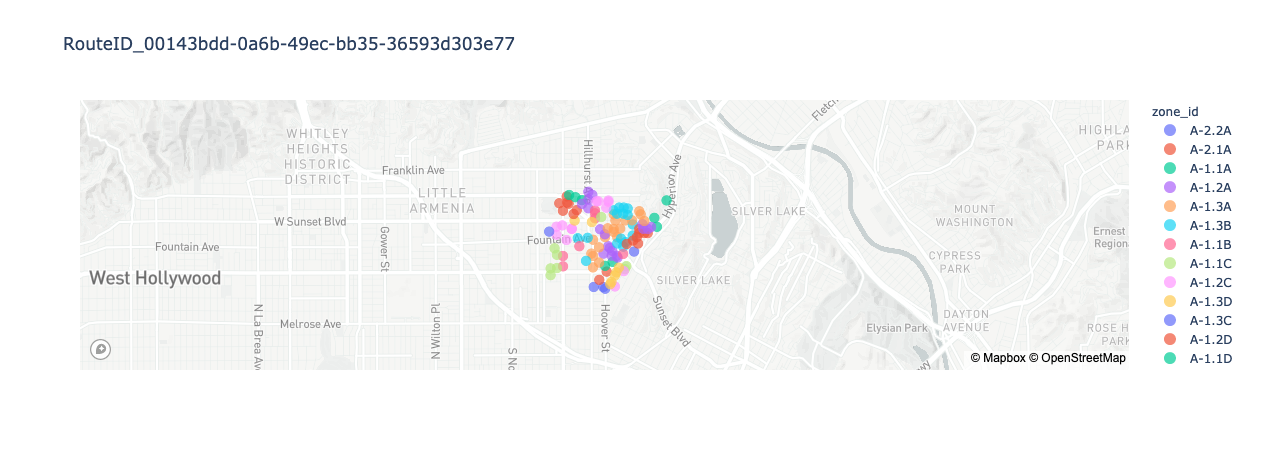

In [13]:
subdat['size'] = 0.1
fig_pts = px.scatter_mapbox(subdat, lat="lat", lon="lng",
                         color="zone_id", title = rid,
                         size = "size", size_max = 8,
                    hover_name="actual", zoom = 12)
fig_pts.show()

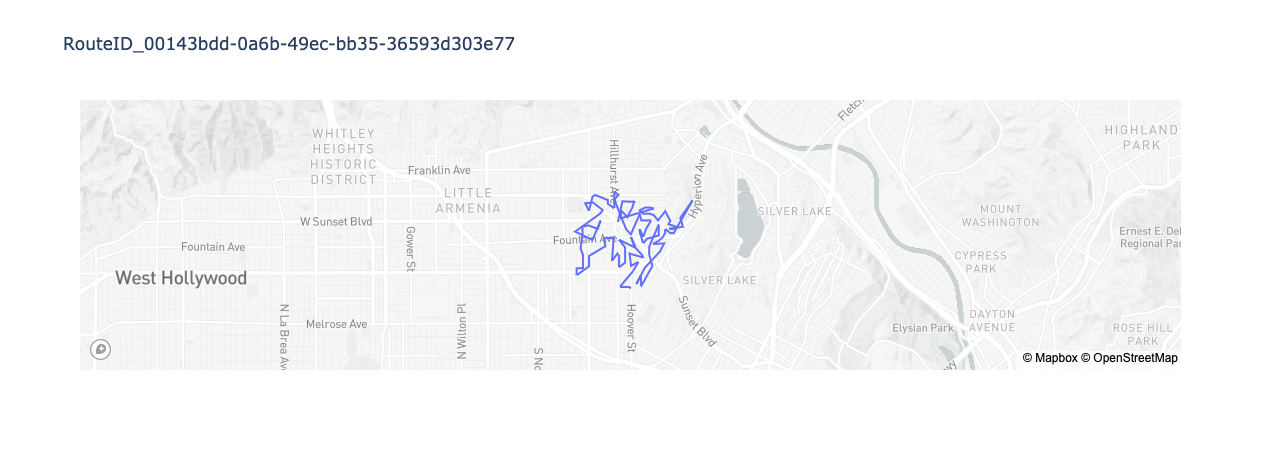

In [14]:
fig_actual = px.line_mapbox(subdat, lat="lat", lon="lng", title = rid,

                    hover_name="actual", zoom = 12)
#fig.update_layout(mapbox_style="dark")
fig_actual.update_geos(fitbounds="locations")
fig_actual.show()

Let's combine these into one plot:

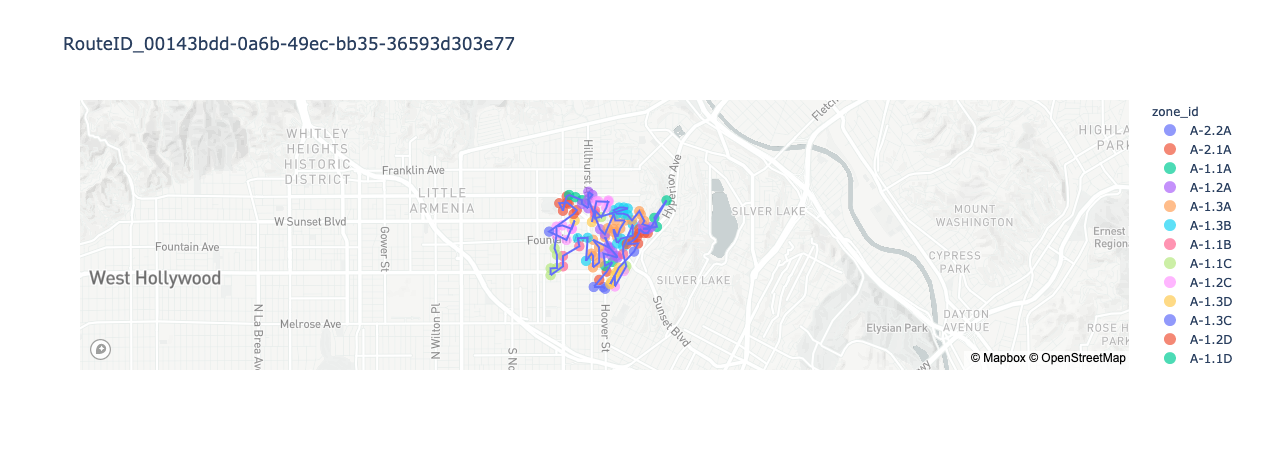

In [15]:
fig = fig_pts.add_trace(fig_actual.data[0])
fig

We could postulate that visitations occur within zone_ids. From the chart, it seems that a new zone is not visited until the current zone is completed.

## NetworkX

Let's start by building a toy adjacency matrix with just five nodes:

In [16]:
A = pd.DataFrame(rtimes).iloc[0:5, 0:5]
G = nx.from_pandas_adjacency(A)

In [17]:
A

AD     AF     AG     BA     BE
AD    0.0  209.8  295.7  284.0  107.9
AF  198.3    0.0  333.6  219.5  178.9
AG  264.9  348.3    0.0  288.2  308.2
BA  268.9  223.2  273.2    0.0  204.5
BE   89.4  219.2  236.4  225.9    0.0

In [18]:
pos = {x: (gdf.lat[x], gdf.lng[x]) for x in gdf.index}

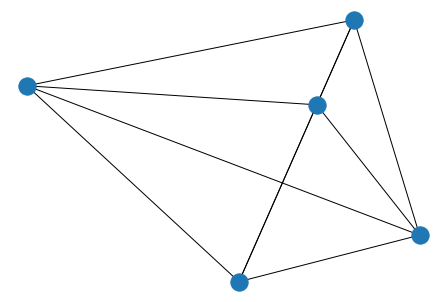

In [19]:
nx.draw(G, pos=pos)
plt.show()

In [20]:
#import dimod
#import dwave_networkx as dnx

#dnx.traveling_salesperson(G, dimod.ExactSolver())

This takes a long time to fit, even for a tiny network of five nodes (I've commented it out)! Clearly this is not even a sustainable local solution.

In [21]:
from simulated_annealing import sa

import osmnx as ox

In [22]:
from landscapes.single_objective import tsp

In [23]:
gdf

lat         lng     type  zone_id  actual name  \
VE  34.007369 -118.143927  Station      NaN       0   VE   
TG  34.088467 -118.284521  Dropoff   A-2.2A       1   TG   
GP  34.088709 -118.284839  Dropoff   A-2.2A       2   GP   
HT  34.088717 -118.286484  Dropoff   A-2.2A       3   HT   
AG  34.089727 -118.285530  Dropoff   A-2.1A       4   AG   
..        ...         ...      ...      ...     ...  ...   
UU  34.101004 -118.283957  Dropoff  P-13.1B     114   UU   
SD  34.100820 -118.283959  Dropoff  P-13.1B     115   SD   
YY  34.100902 -118.285704  Dropoff  P-13.1B     116   YY   
PX  34.100883 -118.286020  Dropoff  P-13.1B     117   PX   
QX  34.097948 -118.286795  Dropoff  P-13.3A     118   QX   

                       geometry  
VE  POINT (-118.14393 34.00737)  
TG  POINT (-118.28452 34.08847)  
GP  POINT (-118.28484 34.08871)  
HT  POINT (-118.28648 34.08872)  
AG  POINT (-118.28553 34.08973)  
..                          ...  
UU  POINT (-118.28396 34.10100)  
SD  POINT (-118.28396 34.10082)  
YY  POINT (-118.28570 34.10090)  
PX  POINT (-118.28602 34.10088)  
QX  POINT (-118.28679 34.09795)  

[119 rows x 7 columns]

In [24]:
df.groupby("zone_id")[["lat", "lng"]].median()

lat         lng
zone_id                       
A-1.1A   34.092003 -118.283887
A-1.1B   34.093119 -118.291750
A-1.1C   34.091408 -118.293212
A-1.1D   34.101474 -118.289609
A-1.2A   34.093458 -118.283405
A-1.2C   34.096991 -118.291518
A-1.2D   34.100562 -118.291027
A-1.3A   34.093460 -118.286591
A-1.3B   34.095641 -118.287800
A-1.3C   34.096583 -118.294127
A-1.3D   34.098157 -118.289765
A-2.1A   34.090314 -118.284893
A-2.2A   34.088709 -118.284839
A-2.3A   34.090347 -118.282857
A-2.3B   34.089872 -118.282083
P-12.1D  34.098539 -118.275631
P-12.2D  34.097114 -118.277580
P-12.3C  34.099611 -118.281420
P-12.3D  34.098613 -118.278541
P-13.1B  34.100883 -118.284328
P-13.1C  34.097035 -118.282907
P-13.1D  34.096078 -118.278775
P-13.2A  34.100535 -118.287399
P-13.2B  34.098661 -118.285183
P-13.2C  34.095338 -118.281215
P-13.2D  34.093749 -118.279560
P-13.3A  34.097948 -118.286795
P-13.3B  34.099181 -118.286250
P-13.3C  34.093403 -118.281442
P-13.3D  34.091470 -118.281009

In [25]:
gdf.index[0]

'VE'

## Baseline models

Let's fit some simple greedy approaches as baselines:

In [26]:
## greedy shortest path
def seq_greedy_shortest(A, start_node):
    """Greedily find the next item by shortest path"""
    node = start_node
    seq = [start_node]
    while A.shape[0] > 1:
        A = A.drop(node)
        node = A[node].index[np.argmin(A[node])]
        seq += [node]
    seq += [start_node]
    return seq

In [27]:

seq = seq_greedy_shortest(pd.DataFrame(rtimes), gdf.index[0])

In [28]:
gdf

lat         lng     type  zone_id  actual name  \
VE  34.007369 -118.143927  Station      NaN       0   VE   
TG  34.088467 -118.284521  Dropoff   A-2.2A       1   TG   
GP  34.088709 -118.284839  Dropoff   A-2.2A       2   GP   
HT  34.088717 -118.286484  Dropoff   A-2.2A       3   HT   
AG  34.089727 -118.285530  Dropoff   A-2.1A       4   AG   
..        ...         ...      ...      ...     ...  ...   
UU  34.101004 -118.283957  Dropoff  P-13.1B     114   UU   
SD  34.100820 -118.283959  Dropoff  P-13.1B     115   SD   
YY  34.100902 -118.285704  Dropoff  P-13.1B     116   YY   
PX  34.100883 -118.286020  Dropoff  P-13.1B     117   PX   
QX  34.097948 -118.286795  Dropoff  P-13.3A     118   QX   

                       geometry  
VE  POINT (-118.14393 34.00737)  
TG  POINT (-118.28452 34.08847)  
GP  POINT (-118.28484 34.08871)  
HT  POINT (-118.28648 34.08872)  
AG  POINT (-118.28553 34.08973)  
..                          ...  
UU  POINT (-118.28396 34.10100)  
SD  POINT (-118.28396 34.10082)  
YY  POINT (-118.28570 34.10090)  
PX  POINT (-118.28602 34.10088)  
QX  POINT (-118.28679 34.09795)  

[119 rows x 7 columns]

In [29]:
gdf["pred"] = pd.Series(np.arange(len(seq)-1), index=seq[:-1])

In [30]:
gdf =  gdf.sort_values("pred")

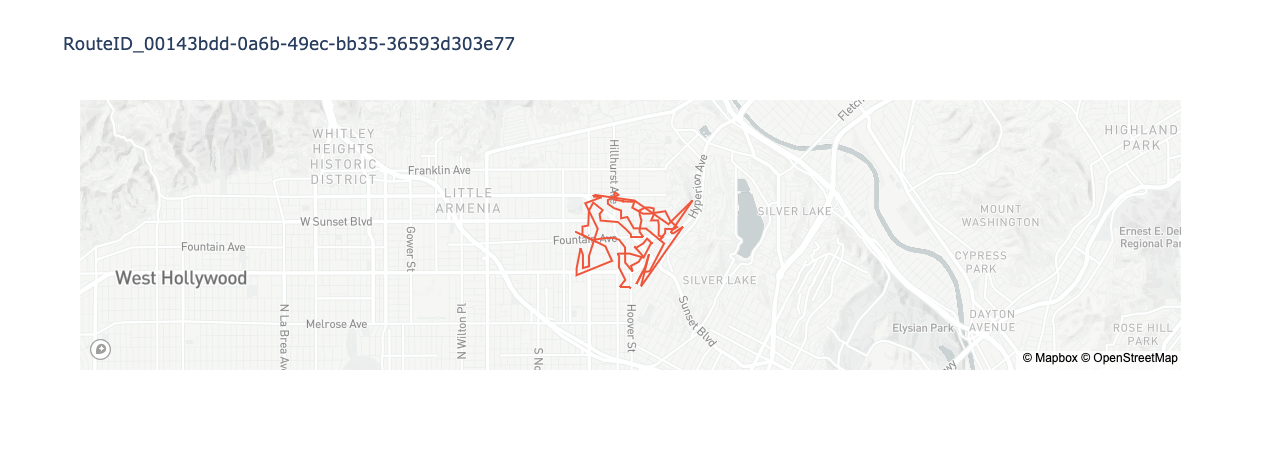

In [31]:
color_discrete_map = {'pred': 'rgb(255,0,0)'}
fig_pred = px.line_mapbox(gdf.query("type == 'Dropoff'"),
                          color_discrete_map=color_discrete_map,
                          lat="lat", lon="lng", title = rid,
                          hover_name="pred", zoom = 12)
fig_pred.show()

While note completely terrible, this does not look great compared to the gold sequence:

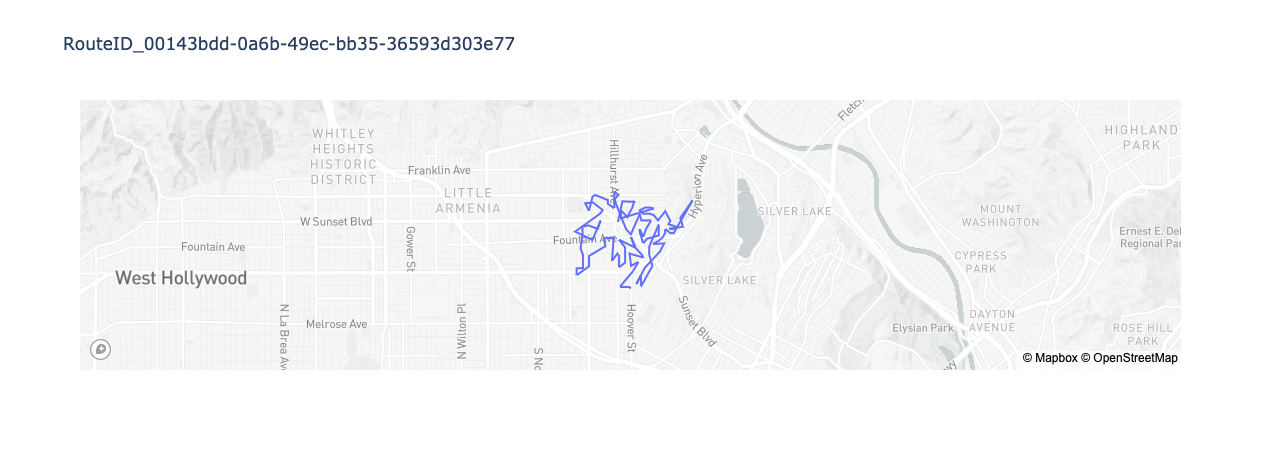

In [32]:
fig_actual.show()

Let's see if anything improves if we try to run the greedy algorithm by zone:

In [33]:
subseqs = dict()
zones = gdf.zone_id.dropna().unique()
for zone in zones:
    idx = gdf[gdf.zone_id == zone].index
    adj = pd.DataFrame(rtimes).loc[idx, idx]
    subseqs[zone] = seq_greedy_shortest(adj, adj.index[0])

In [34]:
subseqs

{'A-2.2A': ['TG', 'GP', 'HT', 'TG'],
 'A-2.1A': ['AG', 'QM', 'AG'],
 'A-1.3A': ['SC', 'IJ', 'XB', 'GU', 'KN', 'NR', 'PT', 'SC'],
 'A-1.2A': ['CW', 'VW', 'JH', 'LB', 'FH', 'DL', 'TK', 'CW'],
 'P-13.2C': ['RA', 'MQ', 'BP', 'MA', 'IM', 'EY', 'RA'],
 'P-13.1D': ['LK', 'QE', 'CK', 'HG', 'FF', 'MO', 'YN', 'LY', 'LK'],
 'A-1.1A': ['SF', 'BY', 'SF'],
 'A-1.3B': ['IW', 'TH', 'KP', 'IW'],
 'A-1.2C': ['UW', 'BA', 'YH', 'DQ', 'CP', 'DN', 'UW'],
 'A-1.2D': ['LD', 'TC', 'CA', 'GN', 'KJ', 'NE', 'AF', 'LD'],
 'A-1.3D': ['UJ', 'UJ'],
 'P-13.3A': ['QX', 'QX'],
 'P-13.2A': ['EO', 'IA', 'UI', 'KG', 'BG', 'CO', 'KM', 'EO'],
 'P-13.1C': ['KU', 'NU', 'GS', 'VC', 'RG', 'BZ', 'ZU', 'YE', 'KU'],
 'P-12.3C': ['AD', 'EC', 'QO', 'UN', 'YJ', 'TY', 'EX', 'AD'],
 'P-12.3D': ['EH', 'SQ', 'XD', 'ZP', 'EH'],
 'P-12.2D': ['IP', 'SI', 'CM', 'HB', 'IP'],
 'P-13.1B': ['WJ', 'SD', 'PX', 'YY', 'UU', 'WJ'],
 'A-1.1D': ['MW', 'KA', 'BT', 'MW'],
 'P-13.3B': ['HR', 'PB', 'BE', 'HR'],
 'P-13.2B': ['ZB', 'ZB'],
 'P-13.2D': ['PS', '

This works, but there is no intelligent notion of where one sequence starts or ends, nor how to connect the zones. Let's try to improve this.

In [35]:
def seq_greedy_byzone(adj, station):
    """Greedy shortest path by zone

    Param:
        adj [np.dataframe]: A full adjacency matrix, with row and
            column indices named after the nodes.
        station [list]: A list of station names.

    """
    # redefine the full adjacency matrix, minus the stations

    A = adj.drop(index=station, columns=station)

    # start the sequence at the node that is farthest from all
    start = A.sum().idxmax()

    seq = station
    zones = set(gdf.zone_id.dropna())
    while len(zones) > 0:
        # determine the zone of the start point
        zone = gdf.zone_id[start]

        # build a sub-adjacency matrix for the zone
        idx = gdf[gdf.zone_id == zone].index
        adj = pd.DataFrame(rtimes).loc[idx, idx]

        # run the greedy algorithm for the zone
        seq.extend(seq_greedy_shortest(adj, start)[:-1])

        # remove the zone from the pool
        zones.remove(zone)

        # find the next point closest to the last local point
        if len(zones) > 0:
            start = A.drop(columns=seq[1:]).loc[seq[-1], :].idxmin()
        else:
            # add the station as the last stop
            seq.extend([seq[0]])
    return seq

In [36]:
station = gdf.loc[gdf['type'] == "Station", "name"].unique().tolist()
adj = pd.DataFrame(rtimes)
seq = seq_greedy_byzone(adj, station)

In [37]:
gdf["pred2"] = pd.Series(np.arange(len(seq)-2), index=seq[1:-1])

In [38]:
gdf

lat         lng     type zone_id  actual name  \
VE  34.007369 -118.143927  Station     NaN       0   VE   
TG  34.088467 -118.284521  Dropoff  A-2.2A       1   TG   
GP  34.088709 -118.284839  Dropoff  A-2.2A       2   GP   
HT  34.088717 -118.286484  Dropoff  A-2.2A       3   HT   
AG  34.089727 -118.285530  Dropoff  A-2.1A       4   AG   
..        ...         ...      ...     ...     ...  ...   
NL  34.091351 -118.293884  Dropoff  A-1.1C      29   NL   
DJ  34.090390 -118.293879  Dropoff  A-1.1C      28   DJ   
KP  34.092428 -118.287800  Dropoff  A-1.3B      22   KP   
MR  34.094510 -118.288950  Dropoff  A-1.1B      25   MR   
HN  34.096583 -118.294127  Dropoff  A-1.3C      40   HN   

                       geometry  pred  pred2  
VE  POINT (-118.14393 34.00737)     0    NaN  
TG  POINT (-118.28452 34.08847)     1  103.0  
GP  POINT (-118.28484 34.08871)     2  104.0  
HT  POINT (-118.28648 34.08872)     3  105.0  
AG  POINT (-118.28553 34.08973)     4  106.0  
..                          ...   ...    ...  
NL  POINT (-118.29388 34.09135)   114    0.0  
DJ  POINT (-118.29388 34.09039)   115    1.0  
KP  POINT (-118.28780 34.09243)   116   10.0  
MR  POINT (-118.28895 34.09451)   117    7.0  
HN  POINT (-118.29413 34.09658)   118   67.0  

[119 rows x 9 columns]

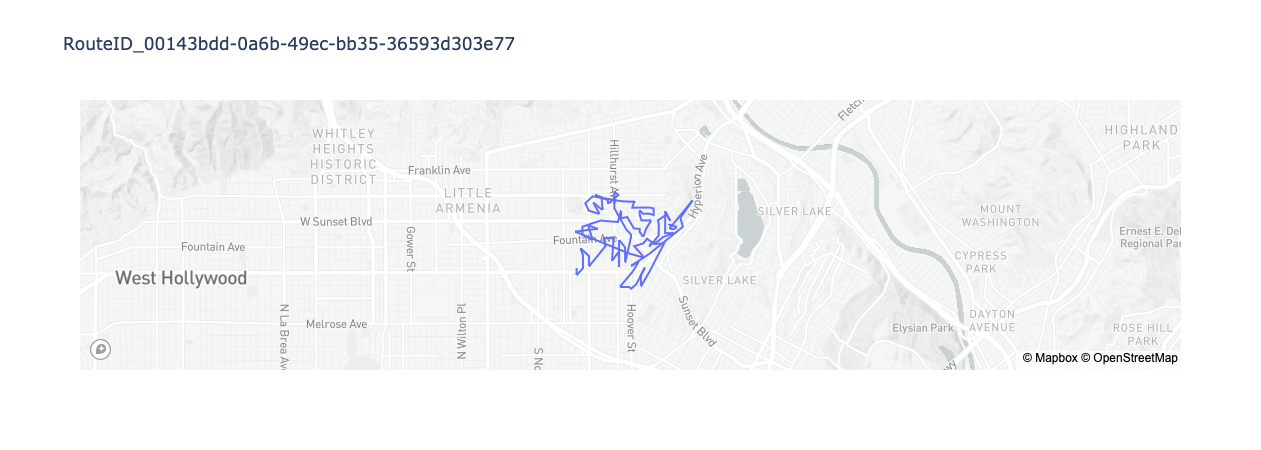

In [39]:
gdf =  gdf.sort_values("pred2")
fig_pred2 = px.line_mapbox(gdf.query("type == 'Dropoff'"),
                          lat="lat", lon="lng", title = rid,
                          hover_name="name", zoom = 12)
fig_pred2.show()

This seems decent, but it is hard to say it it will score well. We'll need to try it.